In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys

%matplotlib inline
from IPython import display


import functions.parse_data as parse
import functions.handy_functions as hf
import torch.nn as nn
import torch.optim as optim
import torch


from multivariate_quantile_regression.network_model import QuantileNetwork

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

from tqdm import tqdm

import os

/tmp/ipykernel_209466/3237860597.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
2024-02-27 08:03:31.943424: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-27 08:03:31.978143: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-27 08:0

In [2]:
# Check if CUDA (GPU support) is available
if torch.cuda.is_available():
    # CUDA is available, so let's set default device to GPU
    torch.set_default_device(0)
    print("CUDA is available. Using GPU.")
else:
    # CUDA is not available, so let's use the CPU
    print("CUDA is not available. Using CPU.")

# Example usage:
tensor = torch.randn(3, 3)  # Create a tensor on the selected device
print("Tensor is on device:", tensor.device)

CUDA is available. Using GPU.
Tensor is on device: cuda:0


In [3]:
channel_labels= ['Cloud_B02','Cloud_B03','Cloud_B04','Cloud_B05','Cloud_B06','Cloud_B07',
                 'Cloud_B08','Cloud_B09','Cloud_B10','Cloud_B11','Cloud_B12','Cloud_B13']

data_water=parse.parse('cloudrm_water.dat')
data_clear=parse.parse('cloudrm_clear.dat')
data_ice=parse.parse('cloudrm_ice.dat')
data_mixed=parse.parse('cloudrm_mixed.dat')

#Concatinate all datasets
#data_all=pd.concat([data_water, data_clear, data_ice, data_mixed])
data_all=pd.concat([data_water, data_ice, data_mixed])
#data_all=pd.concat([data_ice])
data_all=data_all.drop(columns=['Surface_Desc','Cloud_B01','Clear_B01'])
df_truth=data_all.copy()

data_all=data_all[data_all['COT']<3.6]

#data_all=hf.add_MSI_noise(data_all,channel_labels)

In [4]:
##Train test validation split##
X_labels= ['Cloud_B02','Cloud_B03','Cloud_B04','Cloud_B05','Cloud_B06',
           'Cloud_B07','Cloud_B08','Cloud_B09','Cloud_B10','Cloud_B11','Cloud_B12','Cloud_B13',
           'Sat_Zenith_Angle','Sun_Zenith_Angle','Azimuth_Diff_Angle']

#Leave out 'GOT', 'Water_Vapor'
#Band 1 no go.
y_labels=['Clear_B12']

X_truth=df_truth[X_labels]

df=data_all.copy()
#df=hf.normalise_input_df(data_all,X_labels)
#df=hf.add_noise(df,X_labels,sigma=0.001)

##Split data##
X=df[X_labels]
y=df[y_labels]

X_train, X_test, y_train, y_test=train_test_split(X,y,test_size=0.05)

X_test_truth=X_truth.iloc[X_test.index] #Save truth values without normalisation

In [5]:
nepochs=300
batch_size=500

In [6]:
import random

val_size=0.05
validation_indices=np.array(random.sample(range(len(X_train['Cloud_B02'])), int(len(X_train['Cloud_B02'])*val_size)))
train_indices=[i for i in range(len(X_train['Cloud_B02'])) if np.any(validation_indices==i)==False]

quantiles=np.array([0.1,0.5,0.9])

In [110]:
class MLP(nn.Module):
    def __init__(self,n_inputs):
        super(MLP, self).__init__()
        n_nodes=64
        self.linear=nn.Sequential(
                    nn.Linear(n_inputs, n_nodes),
                    nn.ReLU(),
                    nn.Dropout(p=0.2),
                    nn.Linear(n_nodes, n_nodes),
                    nn.ReLU(),
                    nn.Linear(n_nodes, 1) #Output dimesion is number of quantiles times number of target variables
                )

    def forward(self,X):
        X=self.linear(X)
        return X
    
    def predict(self, X):
        X=torch.tensor(X,dtype=torch.float)
        X_mean=torch.mean(X,dim=0,keepdim=True)
        X_std=torch.std(X,dim=0,keepdim=True)
        X = torch.tensor((X - X_mean) / X_std,dtype=torch.float)
        y_hat=self(X)
        return y_hat

In [111]:
model=MLP(len(X_labels))

loss_fn=nn.L1Loss()
optimizer=optim.Adam(model.parameters(),lr=0.03)

In [112]:
from multivariate_quantile_regression.utils import batches

In [113]:
X=torch.tensor(X_train.to_numpy(),dtype=torch.float)#,device=device)
Y=torch.tensor(y_train.to_numpy(),dtype=torch.float)#,device=device) 
n_epochs=300
training_losses=np.zeros(n_epochs)
validation_losses=np.zeros(n_epochs)
validation_losses[0]=100000000000

y_mean=torch.mean(Y,dim=0,keepdim=True)
y_std=torch.std(Y,dim=0,keepdim=True)

tY = torch.tensor((Y - y_mean) / y_std,dtype=torch.float)

for epoch in range(n_epochs):

    print("Epoch"+str(epoch))

    noise=torch.randn(X.shape)
    means=torch.mean(X,dim=0)*0.03
    noise=noise*means.repeat((len(noise[:,0]),1))
    tX=X+noise

    X_mean=torch.mean(tX,dim=0,keepdim=True)
    X_std=torch.std(tX,dim=0,keepdim=True)


    tX = torch.tensor((tX - X_mean) / X_std,dtype=torch.float)


    train_loss=0
    for batch in batches(train_indices, batch_size, shuffle=True):

        idx = torch.tensor(batch,dtype=torch.int64)#,device=device)

        model.train() #Initialise train mode
        model.zero_grad() #Reset gradient

        yhat = model(tX[idx]) #Run algorithm

        loss=loss_fn(yhat,tY[idx]).sum() #Run loss function
        loss.backward() #Calculate gradient

        optimizer.step()

        train_loss=train_loss+loss.data #Increment loss
    
    training_losses[epoch]=train_loss/len(train_indices)

    validation_loss = torch.tensor([0],dtype=torch.float)#,device=device)
    
    for batch_idx, batch in enumerate(batches(validation_indices, batch_size, shuffle=False)):


        idx = torch.tensor(batch,dtype=torch.int64)#,device=device)

        model.eval() #Set evaluation mode
        model.zero_grad() #Reset gradient

        yhat=model(tX[idx])

        validation_loss=validation_loss+loss_fn(yhat, tY[idx]).sum()

    if validation_loss[0]<np.min(validation_losses[validation_losses!=0.0]):
        torch.save(model,'tmp_file')
    
    validation_losses[epoch]=validation_loss/len(validation_indices)

model=torch.load('tmp_file')
os.remove('tmp_file')
print("Best model out of total max epochs found at epoch {}".format(np.argmin(validation_losses)+1))

    


/home/edgelab/.local/lib/python3.10/site-packages/torch/utils/_device.py:77: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)


Epoch0
Epoch1
Epoch2
Epoch3
Epoch4


Epoch5
Epoch6
Epoch7
Epoch8
Epoch9
Epoch10
Epoch11
Epoch12
Epoch13
Epoch14
Epoch15
Epoch16
Epoch17
Epoch18
Epoch19
Epoch20
Epoch21
Epoch22
Epoch23
Epoch24
Epoch25
Epoch26
Epoch27
Epoch28
Epoch29
Epoch30
Epoch31
Epoch32
Epoch33
Epoch34
Epoch35
Epoch36
Epoch37
Epoch38
Epoch39
Epoch40
Epoch41
Epoch42
Epoch43
Epoch44
Epoch45
Epoch46
Epoch47
Epoch48
Epoch49
Epoch50
Epoch51
Epoch52
Epoch53
Epoch54
Epoch55
Epoch56
Epoch57
Epoch58
Epoch59
Epoch60
Epoch61
Epoch62
Epoch63
Epoch64
Epoch65
Epoch66
Epoch67
Epoch68
Epoch69
Epoch70
Epoch71
Epoch72
Epoch73
Epoch74
Epoch75
Epoch76
Epoch77
Epoch78
Epoch79
Epoch80
Epoch81
Epoch82
Epoch83
Epoch84
Epoch85
Epoch86
Epoch87
Epoch88
Epoch89
Epoch90
Epoch91
Epoch92
Epoch93
Epoch94
Epoch95
Epoch96
Epoch97
Epoch98
Epoch99
Epoch100
Epoch101
Epoch102
Epoch103
Epoch104
Epoch105
Epoch106
Epoch107
Epoch108
Epoch109
Epoch110
Epoch111
Epoch112
Epoch113
Epoch114
Epoch115
Epoch116
Epoch117
Epoch118
Epoch119
Epoch120
Epoch121
Epoch122
Epoch123
Epoch124
Epoch125
Epoch126
Ep

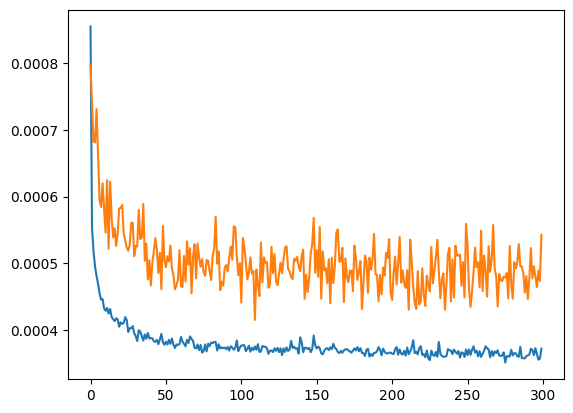

In [117]:
plt.plot(training_losses)
plt.plot(validation_losses)

In [118]:
preds=model.predict(X=X_test.to_numpy()).data.cpu().numpy()*y_std.data.cpu().numpy()+y_mean.data.cpu().numpy()

/home/edgelab/.local/lib/python3.10/site-packages/torch/utils/_device.py:77: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)


In [119]:
mse=mean_squared_error(y_test.to_numpy(),preds)
r2=r2_score(y_test.to_numpy(),preds)

print("MSE: "+str(mse))
print("R2 score: "+str(r2))

MSE: 0.010602864728655379
R2 score: 0.7221236594738352
